Sort people into leagues for curling
KL 8/17/2016; update 8/30/2016; update 9/15/2016; update 12/23/2016

KL 9/1/2017: Updated to add email addresses to output, add new leagues, and use new league managers

This version randomizes the people first

In [467]:
# Before running this:
#     (1) decide on max # of leagues and change that in the input.csv file,
#     (2) decide on nLimit for each league
#     (3) might need to optimize people's priority lists to increase number getting into 4 pm

In [468]:
#the -f does this without user confirmations
%reset -f

In [469]:
setSeed = False

In [470]:
#set the random seed...if a number...will be able to recreate the random numbers
if setSeed == True:
    SEED = 42
elif setSeed == False:
    SEED = None

In [471]:
import pandas as pd
import numpy as np
import math
import csv
import os
from datetime import datetime

#used this to step into the function and debug it, also need line with Tracer()() 
from IPython.core.debugger import Tracer 

%matplotlib inline

Define some functions up top

In [472]:
def addOne(leagueDict,oneLeague,oneName):
    if len(leagueDict[oneLeague])==0: #nothing there yet
        leagueDict[oneLeague] = oneName
    else:     #need to append
        leagueDict[oneLeague] = leagueDict[oneLeague].append(oneName)
    return leagueDict

In [473]:
def addManager(leagueDictionary,r,manager): #here r is the index in...
    useRow = r.index[0]
    #oneName = regSorted.loc[useRow,['lastname', 'firstname']] 
    oneName = regSorted.loc[useRow,['lastname', 'firstname', 'email']] 
    oneName = oneName.to_frame().transpose() #need this format to make nice output
    leagueDictionary[manager] = oneName
    regSorted.loc[useRow,manager]=np.nan
    regTracking.loc[useRow,manager]='yes'
    return leagueDictionary

In [474]:
def addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues):
    #person is interested in open leagues, oneLeague will be index in their next choice
    oneLeague = regSorted.loc[idx,openLeagues].dropna().idxmin()

    #oneName = regSorted.loc[idx,['lastname', 'firstname']] 
    oneName = regSorted.loc[idx,['lastname', 'firstname','email']]
    oneName = oneName.to_frame().transpose() #need this format to make nice output

    if len(leagueDict_open[oneLeague]) < (nLimit.loc[oneLeague,'nLimit']): #room in league
        leagueDict_open = addOne(leagueDict_open,oneLeague,oneName)
        #now that I have added the person to a league, change their priority to NaN
        regSorted.loc[idx,oneLeague] = np.nan
        regTracking.loc[idx,oneLeague] = 'yes'

    elif len(leagueDict_open[oneLeague]) == (nLimit.loc[oneLeague,'nLimit']):
        #league is full...does this person have another league listed?
        #first, set current to NaN
        regSorted.loc[idx,oneLeague] = np.nan
        regTracking.loc[idx,oneLeague] = 'no' #did not get in
        nextPriority = regSorted.loc[idx,openLeagues].dropna().min()
        if math.isnan(nextPriority)!=1: #have a number
            #go to the next league on their list
            nextLeague = regSorted.loc[idx,openLeagues].dropna().idxmin()
            #only add person is league has space
            if len(leagueDict_open[nextLeague]) < (nLimit.loc[nextLeague,'nLimit']):
                leagueDict_open = addOne(leagueDict_open,nextLeague,oneName)
                regSorted.loc[idx,nextLeague] = np.nan
                regTracking.loc[idx,nextLeague] = 'yes'
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==1):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInFirst',oneName)
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==2):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInSecond',oneName)
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==3):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInThird',oneName)
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==4):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInFourth',oneName)
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==5):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInFifth',oneName)
        elif math.isnan(nextPriority)==1:
            trackIssues=addOne(trackIssues,'noAdditionalChoice',oneName)
                           
    return regSorted, regTracking, leagueDict_open, trackIssues

Read in the data

In [475]:
#updated 8/30/2016 to use file from website
fName = 'BackupList_Registrations_forPython.csv' 
#fName = 'registrations_KL_working.csv'
importInfo=pd.read_csv(fName)

In [476]:
#shuffle the information from the website site to match the format in the rest of this file
openLeagues = ['Sunday Night', 'Monday 4PM', 'Monday Night',
               'Wednesday 4PM','Thursday 9AM','Thursday 4PM'] #updated to match the priority list
otherLeagues = ['League_4_Men', 'League_7_Ladies' ,'League_Scrod','League_Tuesday_open_NC']

priorities = ['League_Pri_1','League_Pri_2','League_Pri_3','League_Pri_4','League_Pri_5','League_Pri_6']

regInfo = importInfo.loc[:,(['firstname','lastname','email','League_Number_Open'] + otherLeagues)]

for item in openLeagues:
    regInfo[item] = np.nan

nPeople = len(regInfo.index)
for idx in range(0,nPeople):
    for idxP in enumerate(priorities):
        #remember: enumerate will allow idxP[0] is the number, while idxP[1] is the value
        getOne = importInfo.loc[idx,idxP[1]]
        if getOne != 'None':
            regInfo.loc[idx,getOne] = idxP[0] + 1  #want 1,2,3 and not python zero index

In [477]:
#regInfo.loc[importInfo['lastname']=="O'Connor"] #use this to find one person's registration

In [478]:
#first, how many random numbers so I need?
nPeople = len(regInfo.index)
np.random.seed(SEED)
regInfo['randomNumCol'] = np.random.choice(range(nPeople), nPeople,replace = False)

##put in place to rank people higher if they only want to curl in one championship league
if True:
    for idx in (range(0,nPeople)):
        if regInfo.loc[idx,'League_Number_Open'] != '1':
            regInfo.loc[idx,'randomNumCol'] = regInfo.loc[idx,'randomNumCol'] + 1000

In [479]:
##so now, moving back to the list of people, sort the list by the random number
regSorted = regInfo.sort_values(by = 'randomNumCol', ascending=True)
regSorted.reset_index(inplace = True)
#copy so I can have an output tracking what was done, make after I put in league managers
regTracking = regSorted.copy(deep=True)

In [480]:
regSorted.head()

,index,firstname,lastname,email,League_Number_Open,League_4_Men,League_7_Ladies,League_Scrod,League_Tuesday_open_NC,Sunday Night,Monday 4PM,Monday Night,Wednesday 4PM,Thursday 9AM,Thursday 4PM,randomNumCol
0,50,Al,Duester,aduester@pobox.com,1,No,No,No,Yes,NaN,2.0,NaN,1.0,NaN,NaN,2
1,19,Gabrielle,Belfit,gcapsisb@gmail.com,1,No,Yes,No,Yes,1.0,2.0,NaN,3.0,NaN,NaN,4
2,23,Mark,Benoit,markbenoit@comcast.net,1,No,No,No,No,NaN,NaN,1.0,NaN,NaN,NaN,6
3,184,Bud,Vana,bud.vana@gmail.com,1,No,No,No,No,1.0,NaN,NaN,NaN,NaN,NaN,8
4,200,Carolyn,Wurm,wurmcar@gmail.com,1,No,Yes,Yes,No,NaN,1.0,NaN,2.0,NaN,NaN,9


In [481]:
issueNames = ['notInFirst','notInSecond','notInThird','notInFourth','notInFifth','noAdditionalChoice']
#setup the dictionary to hold the issues
trackIssues = {}
for name in issueNames:
    trackIssues[name] = pd.DataFrame()

In [482]:
#setup the dictionary to hold the people information (start with openLeagues only)
forDictionary = openLeagues
#forDictionary.extend(otherLeagues)
leagueDict_open = {}
for name in forDictionary:
    leagueDict_open[name] = pd.DataFrame()

In [483]:
#set the limit for each league (can set to big numbers to see how oversubscribed each league is)
sevenTeams = 28 #remember league manager already in here
eightTeams = 32
fourteenTeams = 56

d = {'Sunday Night': eightTeams,
     'Monday 4PM': eightTeams,
     'Monday Night': fourteenTeams,
     'Wednesday 4PM': sevenTeams,
     'Thursday 9AM': sevenTeams,
     'Thursday 4PM': sevenTeams,}

nLimit = pd.DataFrame({'nLimit' : d})
del d

In [484]:
# put the manager information into a loop bc need to check later for them, placeholders 9/11/2017
names = [['Bill','Fragaszy'],['Richard',"O'Connor"],['George', 'Bagley'],
        ['Katherine', 'Murphy'],['Joseph', 'Tamucci'],['Bill', 'Gallagher']] #me as placeholder
leagues = ['Sunday Night','Monday 4PM','Monday Night','Wednesday 4PM','Thursday 9AM','Thursday 4PM']

managers = pd.DataFrame(names,columns = ['firstname','lastname'],index = [leagues])
del names,leagues

if True:
    #put the league managers into their league and set their the choice for that league to NaN
    for oL,item in managers.iterrows():
        r = regSorted.loc[(regSorted['lastname']==item.lastname) & (regSorted['firstname']==item.firstname)]
        leagueDict_open = addManager(leagueDict_open,r,oL)       

In [485]:
nPeople

204

In [486]:
iteration = 1
for idx in (range(0,(nPeople-1))):
    if regTracking.loc[idx,'League_Number_Open'] != 'None':
        #only do something if a person is still looking for more leagues...
        rt = regTracking.loc[idx,openLeagues]
        cHave = len(rt[rt=='yes'])
        del rt
        #NOTE: League_Number_Open will return a string...change to int
        if cHave < int(regTracking.loc[idx,'League_Number_Open']): #person wants more 
            onePriority = regSorted.loc[idx,openLeagues].dropna().min() #any more things ranked?   
            if math.isnan(float(onePriority))==False:
                regSorted,regTracking,leagueDict_open,trackIssues = addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues)


In [487]:
#now go backwards through the list to fill the other spots
iteration = 2
for idx in (range((nPeople - 1),0,-1)):
    #ignore person who does not want open leagues:
    if regTracking.loc[idx,'League_Number_Open'] != 'None':
        #only do something if a person is still looking for more leagues...
        rt = regTracking.loc[idx,openLeagues]
        cHave = len(rt[rt=='yes'])
        del rt
        #NOTE: League_Number_Open will return a string...change to int
        if cHave < int(regTracking.loc[idx,'League_Number_Open']): #person wants more 
            onePriority = regSorted.loc[idx,openLeagues].dropna().min() #any more things ranked?   
            if math.isnan(float(onePriority))==False:
                regSorted,regTracking,leagueDict_open,trackIssues = addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues)        

In [488]:
#go forwards again
iteration = 3
for idx in (range(0,(nPeople-1))):
    #ignore person who does not want open leagues:
    if regTracking.loc[idx,'League_Number_Open'] != 'None':
        #only do something if a person is still looking for more leagues...
        rt = regTracking.loc[idx,openLeagues]
        cHave = len(rt[rt=='yes'])
        del rt
        #NOTE: League_Number_Open will return a string...change to int
        if cHave < int(regTracking.loc[idx,'League_Number_Open']): #person wants more 
            onePriority = regSorted.loc[idx,openLeagues].dropna().min() #any more things ranked?   
            if math.isnan(float(onePriority))==False:
                regSorted,regTracking,leagueDict_open,trackIssues = addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues)

In [489]:
##add a fourth iteration...there might be space
#now go backwards through the list to fill the other spots
iteration = 4
for idx in (range((nPeople-1),0,-1)):
    #ignore person who does not want open leagues:
    if regTracking.loc[idx,'League_Number_Open'] != 'None':
        #only do something if a person is still looking for more leagues...
        rt = regTracking.loc[idx,openLeagues]
        cHave = len(rt[rt=='yes'])
        del rt
        #NOTE: League_Number_Open will return a string...change to int
        if cHave < int(regTracking.loc[idx,'League_Number_Open']): #person wants more 
            onePriority = regSorted.loc[idx,openLeagues].dropna().min() #any more things ranked?   
            if math.isnan(float(onePriority))==False:
                regSorted,regTracking,leagueDict_open,trackIssues = addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues)        

In [490]:
for idx in range(nPeople,0,-1):
    print(idx)

204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [491]:
#only one person wants to curl 4x and I know there will not be space...stop here

In [492]:
#make a new dictionary for other leagues...concat with openLeagues when done
# do doubles and competitive league by hand...
#already defined this above...
#otherLeagues = ['League_4_Men', 'League_7_Ladies' ,'League_Scrod']

leagueDict_other = {}
for name in otherLeagues:
    leagueDict_other[name] = pd.DataFrame()

In [493]:
#only have to go through once
for idx, item in regTracking.iterrows():
    for oL in otherLeagues:
    
        oneName = regSorted.loc[idx,['lastname', 'firstname','email']] #updated 12/23/2016
        oneName = oneName.to_frame().transpose() #need this format to make nice output
        if regSorted.loc[idx,oL]=='Yes': #careful with trailing spaces
            leagueDict_other = addOne(leagueDict_other,oL,oneName)
            #now that I have added the person to a league, change their priority to NaN
            regTracking.loc[idx,oL] = 'done'
            regSorted.loc[idx,oL] = np.nan

In [494]:
#combine the two dictionaries
leagueDict_all = leagueDict_open.copy()
leagueDict_all.update(leagueDict_other)

#combine the list of names
allLeagues = list(openLeagues)
allLeagues.extend(otherLeagues)

In [495]:
#finally, export the results, until I have everyone...no need to keep every iteration
folder = 'result_working' 
if not os.path.exists(folder):
    os.makedirs(folder)    
    
# #finally, export the results 
# folder = 'result_' + datetime.now().strftime("%Y%m%d-%H%M%S")
# if not os.path.exists(folder):
#     os.makedirs(folder)
# else:
#     raise ValueError('Something wrong, this folder already exists')    

In [496]:
#change this to sort alphabetically before exporting
for fn in allLeagues:
    fName = '%s.csv' % fn
    #new folder for each run...
    tData = leagueDict_all[fn].sort_values(by = 'lastname')
    tData.to_csv(folder + '/' + fName)

can ran multiple times and saved the output

In [497]:
#count up number of issues
for problem in issueNames:
    print(problem, ': ', len(trackIssues[problem]), ' people in this category')

notInFirst :  0  people in this category
notInSecond :  5  people in this category
notInThird :  0  people in this category
notInFourth :  0  people in this category
notInFifth :  0  people in this category
noAdditionalChoice :  20  people in this category


,nPeople
League_4_Men,27.0
League_7_Ladies,28.0
League_Scrod,23.0
League_Tuesday_open_NC,27.0


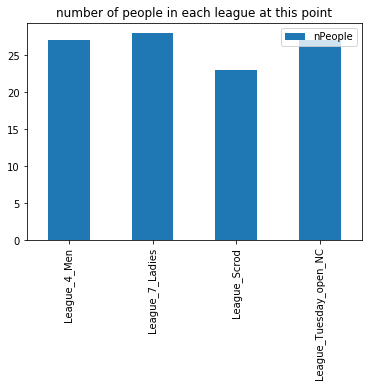

In [498]:
#do some plotting...visually see how people distributed
gather = pd.DataFrame(np.nan, index = otherLeagues, columns=['nPeople'])
for name in otherLeagues:
    gather.loc[name,'nPeople'] = len(leagueDict_all[name])
    
gather.plot(kind = 'bar',title='number of people in each league at this point')
gather

,nPeople
Sunday Night,32.0
Monday 4PM,32.0
Monday Night,40.0
Wednesday 4PM,28.0
Thursday 9AM,20.0
Thursday 4PM,28.0


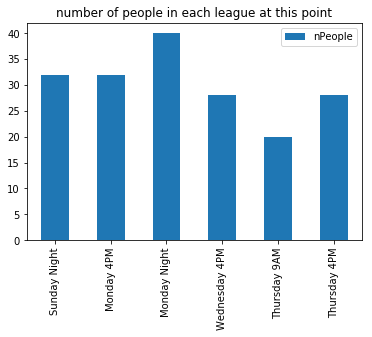

In [499]:
#do some plotting...visually see how people distributed
gather = pd.DataFrame(np.nan, index = openLeagues, columns=['nPeople'])
for name in openLeagues:
    gather.loc[name,'nPeople'] = len(leagueDict_open[name])
    
gather.plot(kind = 'bar',title='number of people in each league at this point')
gather

In [500]:
#gather up the number of people with # 'yes' < League_Number_Open
outcome = regTracking.copy(deep = True)

for idx, item in regTracking.iterrows():
    if regTracking.loc[idx,'League_Number_Open'] != 'None':
        r = regTracking.loc[idx,openLeagues]
        nLeagues = 0
        for item in range(0,len(r)):
            if r[item] == 'yes':
                nLeagues = nLeagues + 1
        if nLeagues == int(regTracking.loc[idx,'League_Number_Open']):
            #delete from the dataframe
            outcome.drop(idx,inplace = True)
    else: #did not want open leagues, drop them too
        outcome.drop(idx,inplace = True)
        
outcome.sort_values(by = 'League_Number_Open', inplace = True)

In [501]:
len(outcome)

25

In [502]:
#alphabetize regTracking before saving
regTracking.sort_values(by = 'lastname',inplace = True)

outcome.to_csv(folder + '/exportOutcome.csv')
regTracking.to_csv(folder + '/exportTracking.csv')
regSorted.to_csv(folder + '/exportSorted.csv')
regInfo.to_csv(folder + '/exportInfo.csv')

In [503]:
#can run multiple times and see what the best possible outcome is...would want to keep that...

In [504]:
for problem in issueNames:
    print(problem, ': ', len(trackIssues[problem]), ' people in this category')

notInFirst :  0  people in this category
notInSecond :  5  people in this category
notInThird :  0  people in this category
notInFourth :  0  people in this category
notInFifth :  0  people in this category
noAdditionalChoice :  20  people in this category


In [505]:
outcome

,index,firstname,lastname,email,League_Number_Open,League_4_Men,League_7_Ladies,League_Scrod,League_Tuesday_open_NC,Sunday Night,Monday 4PM,Monday Night,Wednesday 4PM,Thursday 9AM,Thursday 4PM,randomNumCol
110,38,Darryl,Christensen,darrylch@live.com,2,No,No,No,No,NaN,NaN,NaN,yes,NaN,no,1000
201,137,Stephen,O'Neil,soneil022212@gmail.com,2,done,No,No,No,NaN,no,NaN,yes,NaN,NaN,1199
200,64,Penny,Gallagher,gallpenny.ma@gmail.com,2,No,No,No,No,NaN,no,NaN,yes,NaN,no,1197
198,179,Daniel,Trainor,dtrainor115@comcast.net,2,No,No,No,No,NaN,no,NaN,NaN,yes,no,1195
195,181,Cathlene,Uhl,cathlenejuhl@gmail.com,2,No,No,No,No,no,NaN,yes,NaN,NaN,NaN,1185
194,20,Karin,Benedict,KBPisces@aol.com,2,No,No,No,No,NaN,no,NaN,yes,NaN,no,1184
189,14,Frank,Balas,fpbalas@gmail.com,2,done,No,No,No,NaN,yes,NaN,no,NaN,NaN,1174
188,88,Pat,Kavanagh,PKavanagh5@aol.com,2,No,No,No,No,yes,NaN,NaN,no,NaN,no,1172
185,170,Billy,Sullivan,billy195341@gmail.com,2,No,No,No,No,yes,NaN,NaN,NaN,NaN,no,1168
183,148,Brian,Pijanowski,BPIJ@aol.com,2,done,No,No,No,NaN,no,NaN,yes,NaN,NaN,1162
